# Arboles de decisión
**Diego Díaz Fonseca ~ B92602**

## Imports

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics         import confusion_matrix
from sklearn.tree            import DecisionTreeClassifier

## Funciones axiliares

In [9]:
def Gini(y):
  frecuencies       = y.value_counts(sort=False)
  totalObservations = y.count()
  probabilities     = frecuencies / totalObservations
  return 1-(probabilities**2).sum()

def Gini_split(ys):
  individualsPerChildren = np.array(list(map(lambda x: len(x), ys)))
  fathersIndividuals     = individualsPerChildren.sum()
  ratios                 = individualsPerChildren / fathersIndividuals
  ginis                  = np.array(list(map(lambda x: Gini(x), ys)))
  return (ratios * ginis).sum()

def get_index(array, value):
  return np.where(array == value)[0][0]

def exactitud(confusion_matrix):
  return confusion_matrix.diagonal().sum()/confusion_matrix.sum()

def precisiones(confusion_matrix):
  precisiones = []
  for i, number in enumerate(confusion_matrix.diagonal()):
    precisiones.append(number/confusion_matrix[i,:].sum())
  return np.array(precisiones)

def exhaustividades(confusion_matrix):
  exhaustividades = []
  for i, number in enumerate(confusion_matrix.diagonal()):
    exhaustividades.append(number/confusion_matrix[:,i].sum())
  return np.array(exhaustividades)

def F1_scores(precisiones, exhaustividades):
  return 2*precisiones*exhaustividades/(precisiones+exhaustividades)

def imprimir_metrica_por_clase(metrica):
  to_print = ("\tClase " + str(i) + ": " + str(metrica[i]) for i in range(len(metrica)))
  for string in to_print:
    print(string)

## Implementación árbol

In [2]:
class Node:
  def __init__(self, x, y):
    self.x            = x
    self.y            = y
    self.childl       = None
    self.childr       = None
    self.NodeClass    = None
    self.isLeaf       = False
    self.gini         = Gini(y)
    self.split_type   = None
    self.split_value  = None
    self.split_column = None

  def getClassMode(self):
    return self.y.mode()[0]

  def dataSameClass(self):
    return all(self.y.iloc[0] == self.y)

  def updateSplit(self, Stype, value, column):
    self.split_type   = Stype
    self.split_value  = value
    self.split_column = column

  def getCount(self):
    if self.isLeaf:
      return self.y[self.y == self.NodeClass].count()
    else:
      return self.y.count()

In [3]:
class DecisionTree:
  def __init__(self):
    self.root = None
 
  def fit(self, x, y, max_depth = None):
    self.root = Node(x,y)
    if not self.__isLeaf(self.root, max_depth):
      dataLeft, dataRight = self.__findBestSplit(self.root)
      if dataLeft is not None and dataRight is not None:
        newMaxDepth = max_depth-1 if max_depth is not None else None
        self.root.childl = DecisionTree()
        self.root.childl.fit(*dataLeft,  newMaxDepth)
        self.root.childr = DecisionTree()
        self.root.childr.fit(*dataRight, newMaxDepth)
      else:
        self.root.NodeClass = self.root.getClassMode()
        self.root.isLeaf = True

  def __isLeaf(self, node, max_depth):
    node.isLeaf = True
    if node.dataSameClass():
      node.NodeClass = node.y.iloc[0]
    elif max_depth == 0:
      node.NodeClass = node.getClassMode()
    else:
      node.isLeaf = False
    
    return node.isLeaf

  def __findBestSplit(self, node):
    numericalColumns     = node.x.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns
    categoricalColumns   = node.x.select_dtypes(exclude=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns
    bestNumericalSplit   = self.__findBestNumericalSplit(numericalColumns, node)
    bestCategoricalSplit = self.__findBestCategoricalSplit(categoricalColumns, node)

    if bestCategoricalSplit[4] == 0 and bestNumericalSplit[4] == 0:
      return (None, None)
    if bestCategoricalSplit[4] > bestNumericalSplit[4]:
      node.updateSplit("categorical", *bestCategoricalSplit[2:4])
      return bestCategoricalSplit[:2]
    else:
      node.updateSplit("numerical", *bestNumericalSplit[2:4])
      return bestNumericalSplit[:2]

  def __findBestNumericalSplit(self, numericalColumns, node):
    bestFoundIG = -1; bestSplitData = (None, None); 
    bestValue   = 0 ; bestColumn    = "columna"
    for column in numericalColumns:
      values   = node.x[column]
      maxValue = values.max(); minValue = values.min()
      if minValue != maxValue:
        testSplits = np.linspace(minValue, maxValue, num=10)
        for point in testSplits:
          leftDataIndex  = values[values <= point].index
          leftTargets    = node.y[leftDataIndex]
          rightDataIndex = values[values >  point].index
          rightTargets   = node.y[rightDataIndex]
          splitValue = Gini_split([leftTargets, rightTargets])
          newIG      = node.gini - splitValue
          if newIG > bestFoundIG:
            bestFoundIG   = newIG
            bestSplitData = (
                (node.x.loc[leftDataIndex] , leftTargets ), 
                (node.x.loc[rightDataIndex], rightTargets)
            )
            bestValue = point ; bestColumn = column
    
    return (*bestSplitData, bestValue, bestColumn, bestFoundIG)

  def __findBestCategoricalSplit(self, categoricalColumns, node):
    bestFoundIG = -1; bestSplitData = (None, None)
    bestValue   = 0 ; bestColumn = "columna"
    for column in categoricalColumns:
      values     = node.x[column]
      categories = values.unique()
      if len(categories) > 1:
        for categorie in categories:
          leftDataIndex   = values[values == categorie].index
          leftTargets     = node.y[leftDataIndex]
          rightDataIndex  = values[values != categorie].index
          rightTargets    = node.y[rightDataIndex]
          splitValue      = Gini_split([leftTargets, rightTargets])
          newIG           = node.gini - splitValue
          if newIG > bestFoundIG:
            bestFoundIG   = newIG
            bestSplitData = (
                (node.x.loc[leftDataIndex] , leftTargets ), 
                (node.x.loc[rightDataIndex], rightTargets)
            )
            bestValue = categorie ; bestColumn = column
    
    return (*bestSplitData, bestValue, bestColumn, bestFoundIG)

  def predict(self, x):
    predictions = pd.Series(dtype="object")
    prediction_number = 0
    for index, row in x.iterrows():
      predictions.loc[prediction_number] = self.__classify(row)
      prediction_number += 1

    return predictions

  def __classify(self, data):
    subtree = None
    if self.root.isLeaf:
      return self.root.NodeClass

    if self.root.split_type == "numerical":
      subTree = self.__getSubTree(data, self.root, lambda x,y: x <= y)
    else:
      subTree = self.__getSubTree(data, self.root, lambda x,y: x == y)

    return subTree.__classify(data)
  
  def __getSubTree(self, data, node, f):
    valueToClassify = data[node.split_column]
    if f(valueToClassify,node.split_value):
      return node.childl
    else:
      return node.childr

  def to_dict(self):
    if self.root.isLeaf:
      return {
        "type"  : "leaf", 
        "class" : self.root.NodeClass, 
        "count" : self.root.getCount()
      }
    else:
      return {
        "type"         : "split",
        "gini"         : self.root.gini,
        "count"        : self.root.getCount(),
        "split-type"   : self.root.split_type,
        "split-column" : self.root.split_column,
        "split-value"  : self.root.split_value,
        "child-left"   : self.root.childl.to_dict(),
        "child-right"  : self.root.childr.to_dict()
      }

  def calculate_confusion_matrix(self, predict, real):
    classes        = real.unique()
    amount_classes = len(classes)
    confusion      = np.zeros(shape=(amount_classes, amount_classes))
    for i, prediction in enumerate(predict):
      prediction_index = get_index(classes, prediction)
      real_index       = get_index(classes, real.iloc[i])
      confusion[real_index, prediction_index] += 1
      
    return confusion

## Pruebas

### Pruebas con mushrooms.csv

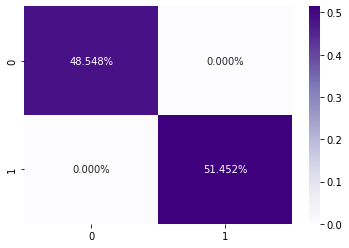

In [7]:
df = pd.read_csv('mushrooms.csv')
y = df['class']
x = df.drop(columns=['class'])
X_train_mushrooms, X_test_mushrooms, y_train_mushrooms, y_test_mushrooms = train_test_split ( 
    x, y, test_size=0.25, random_state=666
)
tree = DecisionTree()
tree.fit(X_train_mushrooms, y_train_mushrooms)
Y = tree.predict(X_test_mushrooms)
CM = tree.calculate_confusion_matrix(Y, y_test_mushrooms)
sns.heatmap(CM/np.sum(CM), annot=True, fmt='.3%', cmap='Purples') 

In [11]:
exact = exactitud(CM)
print("Exactitud modelo: ", exact)

prec = precisiones(CM)
print("Precisiones:")
imprimir_metrica_por_clase(prec)

exhaus = exhaustividades(CM)
print("Exhaustividades:")
imprimir_metrica_por_clase(exhaus)

f = F1_scores(prec, exhaus)
print("F1_scores:")
imprimir_metrica_por_clase(f)

Exactitud modelo:  1.0
Precisiones:
	Clase 0: 1.0
	Clase 1: 1.0
Exhaustividades:
	Clase 0: 1.0
	Clase 1: 1.0
F1_scores:
	Clase 0: 1.0
	Clase 1: 1.0


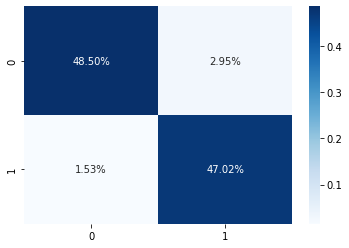

In [ ]:
tree = DecisionTreeClassifier(criterion='gini', random_state=0, max_depth = 3)
for col in X_train_mushrooms.columns:
  X_train_mushrooms[col] = X_train_mushrooms[col].astype('category')
  X_train_mushrooms[col] = X_train_mushrooms[col].cat.codes

  X_test_mushrooms[col] = X_test_mushrooms[col].astype('category')
  X_test_mushrooms[col] = X_test_mushrooms[col].cat.codes

tree.fit(X_train_mushrooms, y_train_mushrooms)
prediction = tree.predict(X_test_mushrooms)
CM = confusion_matrix(y_test_mushrooms, prediction)
sns.heatmap(CM/np.sum(CM), annot=True, fmt='.2%', cmap='Blues')

In [ ]:
exact = exactitud(CM)
print("Exactitud modelo: ", exact)

prec = precisiones(CM)
print("Precisiones:")
imprimir_metrica_por_clase(prec)

exhaus = exhaustividades(CM)
print("Exhaustividades:")
imprimir_metrica_por_clase(exhaus)

F1_scores(prec, exhaus )
print("F1_scores:")
imprimir_metrica_por_clase(F1_scores)

Exactitud modelo:  0.9551944854751354
Precisiones:
	Clase 0: 0.9425837320574163
	Clase 1: 0.9685598377281948
Exhaustividades:
	Clase 0: 0.9425837320574163
	Clase 1: 0.9685598377281948
F1_scores:
	Clase 0: 0.9425837320574163
	Clase 1: 0.9685598377281948


### Pruebas con iris.data

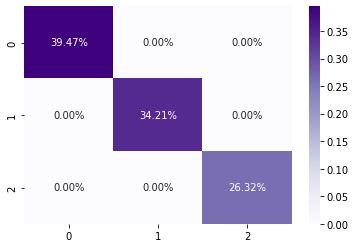

In [ ]:
df = pd.read_csv('iris.data', names=['sepal-length','sepal-width','petal-length','petal-width','class'])
y = df['class']
x = df.drop(columns=['class'])
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split ( 
    x, y, test_size=0.25, random_state=666
)
tree = DecisionTree()
tree.fit(X_train_iris, y_train_iris)
Y = tree.predict(X_test_iris)
CM = tree.calculate_confusion_matrix(Y, y_test_iris)
sns.heatmap(CM/np.sum(CM), annot=True, fmt='.2%', cmap='Purples')

In [ ]:
exact = exactitud(CM)
print("Exactitud modelo: ", exact)

prec = precisiones(CM)
print("Precisiones:")
imprimir_metrica_por_clase(prec)

exhaus = exhaustividades(CM)
print("Exhaustividades:")
imprimir_metrica_por_clase(exhaus)

F1_scores(prec, exhaus )
print("F1_scores:")
imprimir_metrica_por_clase(F1_scores)

Exactitud modelo:  1.0
Precisiones:
	Clase 0: 1.0
	Clase 1: 1.0
	Clase 2: 1.0
Exhaustividades:
	Clase 0: 1.0
	Clase 1: 1.0
	Clase 2: 1.0
F1_scores:
	Clase 0: 1.0
	Clase 1: 1.0
	Clase 2: 1.0


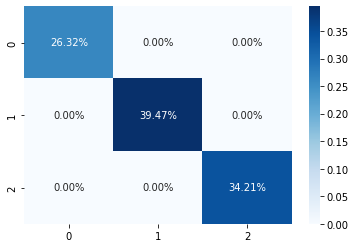

In [ ]:
tree = DecisionTreeClassifier(criterion='gini', random_state=0, max_depth = 3)
tree.fit(X_train_iris, y_train_iris)
prediction = tree.predict(X_test_iris)
CM = confusion_matrix(y_test_iris, prediction)
sns.heatmap(CM/np.sum(CM), annot=True, fmt='.2%', cmap='Blues')

In [ ]:
exact = exactitud(CM)
print("Exactitud modelo: ", exact)

prec = precisiones(CM)
print("Precisiones:")
imprimir_metrica_por_clase(prec)

exhaus = exhaustividades(CM)
print("Exhaustividades:")
imprimir_metrica_por_clase(exhaus)

F1_scores(prec, exhaus )
print("F1_scores:")
imprimir_metrica_por_clase(F1_scores)

Exactitud modelo:  1.0
Precisiones:
	Clase 0: 1.0
	Clase 1: 1.0
	Clase 2: 1.0
Exhaustividades:
	Clase 0: 1.0
	Clase 1: 1.0
	Clase 2: 1.0
F1_scores:
	Clase 0: 1.0
	Clase 1: 1.0
	Clase 2: 1.0


### Pruebas con titanic.csv

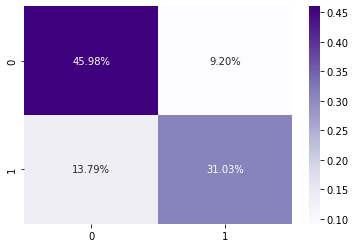

In [ ]:
df = pd.read_csv('titanic.csv')
df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin']).dropna()
y = df['Survived']
x = df.drop(columns=['Survived'])
x['Pclass'] = x['Pclass'].astype('category')
X_train_titanic, X_test_titanic, y_train_titanic, y_test_titanic = train_test_split ( 
    x, y, test_size=0.25, random_state=666
)
tree = DecisionTree()
tree.fit(X_train_titanic, y_train_titanic)
Y = tree.predict(X_test_titanic)
CM = tree.calculate_confusion_matrix(Y, y_test_titanic)
sns.heatmap(CM/np.sum(CM), annot=True, fmt='.2%', cmap='Purples')

In [ ]:
exact = exactitud(CM)
print("Exactitud modelo: ", exact)

prec = precisiones(CM)
print("Precisiones:")
imprimir_metrica_por_clase(prec)

exhaus = exhaustividades(CM)
print("Exhaustividades:")
imprimir_metrica_por_clase(exhaus)

F1_scores(prec, exhaus )
print("F1_scores:")
imprimir_metrica_por_clase(F1_scores)

Exactitud modelo:  0.8505747126436781
Precisiones:
	Clase 0: 0.9444444444444444
	Clase 1: 0.7350427350427351
Exhaustividades:
	Clase 0: 0.9444444444444444
	Clase 1: 0.7350427350427351
F1_scores:
	Clase 0: 0.9444444444444444
	Clase 1: 0.7350427350427351


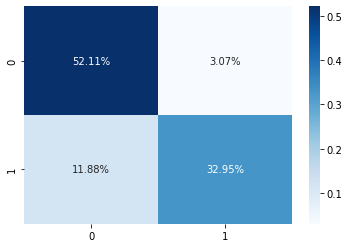

In [ ]:
tree = DecisionTreeClassifier(criterion='gini', random_state=0, max_depth = 3)
for col in ["Sex","Embarked"]:
  X_train_titanic[col] = X_train_titanic[col].astype('category')
  X_train_titanic[col] = X_train_titanic[col].cat.codes

  X_test_titanic[col] = X_test_titanic[col].astype('category')
  X_test_titanic[col] = X_test_titanic[col].cat.codes

tree.fit(X_train_titanic, y_train_titanic)
prediction = tree.predict(X_test_titanic)
CM = confusion_matrix(y_test_titanic, prediction)
sns.heatmap(CM/np.sum(CM), annot=True, fmt='.2%', cmap='Blues')

In [ ]:
exact = exactitud(CM)
print("Exactitud modelo: ", exact)

prec = precisiones(CM)
print("Precisiones:")
imprimir_metrica_por_clase(prec)

exhaus = exhaustividades(CM)
print("Exhaustividades:")
imprimir_metrica_por_clase(exhaus)

F1_scores(prec, exhaus )
print("F1_scores:")
imprimir_metrica_por_clase(F1_scores)

Exactitud modelo:  0.8505747126436781
Precisiones:
	Clase 0: 0.9444444444444444
	Clase 1: 0.7350427350427351
Exhaustividades:
	Clase 0: 0.9444444444444444
	Clase 1: 0.7350427350427351
F1_scores:
	Clase 0: 0.9444444444444444
	Clase 1: 0.7350427350427351
